In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Pierwszy przykład sieci neuronowej

Nie przejmuj się, jeżeli nie zrozumiesz wszystkich elementów tego przykładu. Jest to normalne, jeżeli nie masz doświadczenia w pracy z biblioteką Keras ani innym podobnym do niej pakietem. Prawdopodobnie jeszcze nawet nie zainstalowałeś pakietu Keras… To niczemu nie przeszkadza. W kolejnym rozdziale opiszę każdy element tego przykładu w sposób szczegółowy. W związku z tym nie przejmuj się, jeżeli niektóre rzeczy wydadzą Ci się czarną magią! Musimy od czegoś zacząć.

W zaprezentowanym przykładzie próbujemy rozwiązać problem klasyfikacji obrazów w skali szarości przedstawiających ręcznie zapisane cyfry (obrazy te mają rozdzielczość 28x28 pikseli). Chcemy podzielić je na 10 kategorii (cyfry od 0 do 9). Będziemy korzystać ze zbioru danych MNIST, który jest uznawany przez środowisko analityków za zbiór klasyczny. Istnieje on tak długo, jak długa jest historia uczenia maszynowego. Zbiór ten zawiera 60 000 obrazów treningowych oraz 10 000 obrazów testowych. Został on utworzony przez Narodowy Instytut Standaryzacji i Technologii (NIST) w latach 80. ubiegłego wieku. Rozwiązanie wspomnianego problemu można porównać do wyświetlenia napisu „Witaj, świecie!” podczas nauki nowego języka programowania. Zbiór ten jest również używany w celu sprawdzania tego, czy algorytm działa poprawnie. Jeżeli zaczniesz zawodowo zajmować się uczeniem maszynowym, to odkryjesz, że zbiór MNIST pojawia się ciągle w różnych pracach naukowych, artykułach publikowanych w internecie itd. Na rysunku 2.1 przedstawiono wybrane elementy tego zbioru.


Zbiór danych MNIST jest dołączony do pakietu Keras w formie czterech tablic Numpy:

In [3]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Tablice train_images i train_labels tworzą treningowy zbiór danych. Będzie on używany podczas trenowania modelu. Do testowania posłuży nam testowy zbiór danych, składający się z tablic test_images i test_labels. Obrazy są zakodowane w formie tablic Numpy, a etykiety mają formę tablicy cyfr (od 0 do 9). Do każdego obrazu przypisana jest tylko jedna etykieta.

Przyjrzyjmy się treningowemu zbiorowi danych:

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

A teraz zobaczmy, jak wyglądają dane testowe:

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

In [9]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Będziemy pracować według następującego przepływu roboczego: najpierw będziemy trenować sieć neuronową na danych treningowych: train_images i train_labels. Sieć nauczy się kojarzyć obrazy i etykiety. Następnie nasza sieć wygeneruje przewidywania dotyczące zbioru test_images, a uzyskane wyniki porównamy z etykietami test_labels.

Zbudujmy naszą sieć. Przypominam, że nie musisz jeszcze rozumieć wszystkiego, co się dzieje w tym przykładzie.

In [10]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

Głównym blokiem składowym sieci neuronowej jest warstwa (ang. layer). Jest to moduł przetwarzania danych, który można traktować jako filtr danych. Dane wychodzące z filtra mają bardziej przydatną formę od danych do niego wchodzących. Niektóre warstwy dokonują ekstrakcji reprezentacji kierowanych do nich danych — reprezentacje te powinny ułatwiać rozwiązanie problemu, z którym się zmagamy. Większość uczenia głębokiego składa się z łączenia ze sobą prostych warstw w celu zaimplementowania progresywnej destylacji danych. Model uczenia głębokiego jest jak sito przetwarzające dane składające się z coraz drobniejszych siatek — warstw.

Nasza sieć składa się z sekwencji dwóch warstw Dense, które są ze sobą połączone w sposób gęsty (dochodzi tu do gęstego połączenia). Druga warstwa jest dziesięcioelementową warstwą softmax — warstwa ta zwróci tablicę 10 wartości prawdopodobieństwa (suma wszystkich tych wartości jest równa 1). Każdy z tych wyników określa prawdopodobieństwo tego, że na danym obrazie przedstawiono daną cyfrę (obraz może przedstawiać jedną z dziesięciu cyfr).

Na etapie kompilacji musimy określić jeszcze trzy rzeczy w celu przygotowania sieci do trenowania. Są to:

* Funkcja straty — funkcja ta definiuje sposób pomiaru wydajności sieci podczas przetwarzania treningowego zbioru danych, a więc pozwala na dostrajanie parametrów sieci we właściwym kierunku.
* Optymalizator — mechanizm dostrajania sieci na podstawie danych zwracanych przez funkcje straty.
* Metryki monitorowane podczas trenowania i testowania — tutaj interesuje nas jedynie dokładność (część obrazów, która została właściwie sklasyfikowana).

W kolejnych dwóch rozdziałach wyjaśnię cel stosowania funkcji straty i optymalizatora.

In [11]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Zanim rozpoczniemy trenowanie, zmienimy kształt danych tak, aby przyjęły kształt oczekiwany przez sieć, i przeskalujemy je do wartości z zakresu [0, 1]. Początkowo nasze obrazy treningowe były zapisywane w postaci macierzy o wymiarach (60000, 28, 28), zawierającej wartości z zakresu [0, 255], i typie uint8. Przekształcamy je w tablicę typu float32 o wymiarach (60000, 28 * 28), zawierającą wartości od 0 do 1.

In [12]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

Musimy dodatkowo zakodować etykiety za pomocą kategorii (proces ten wyjaśnię w rozdziale 3.):

In [13]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [14]:
network.fit(train_images, train_labels, epochs=1, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.2544 - acc: 0.9271
Epoch 2/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.1038 - acc: 0.9693
Epoch 3/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0673 - acc: 0.9798
Epoch 4/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0493 - acc: 0.9852
Epoch 5/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0371 - acc: 0.9888
Epoch 6/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0286 - acc: 0.9916
Epoch 7/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0213 - acc: 0.9938
Epoch 8/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0167 - acc: 0.9953
Epoch 9/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0130 - acc: 0.9962
Epoch 10/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.0100 - acc: 0.9972

In [15]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


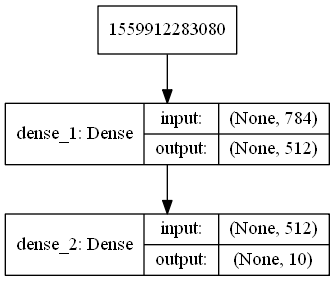

In [16]:
# wyświetlenie modelu
from keras.utils import plot_model
from IPython.display import Image
plot_model(network, show_shapes=True, to_file="model.png");
Image("model.png")

Podczas trenowania wyświetlane są dwie wartości: strata sieci jej dokładność (obie wartości dotyczą treningowego zbioru danych).

Podczas trenowania szybko osiągamy dokładność 0,989 (98,9%). Teraz możemy sprawdzić dokładność przetwarzania testowego zbioru danych:


In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

In [ ]:
print('test_acc:', test_acc)


W przypadku testowego zbioru danych uzyskaliśmy dokładność na poziomie 97,8%, a więc wartość nieco niższą niż dla zbioru treningowego. Różnica między tymi wartościami wynika z nadmiernego dopasowania. Modele uczenia maszynowego mają tendencję do niższej dokładności przetwarzania nowych danych, niż to miało miejsce w przypadku danych treningowych. Zagadnienie to jest głównym tematem rozdziału 3.

To tyle, jeżeli chodzi o nasz pierwszy przykład — właśnie zobaczyłeś, że zbudowanie i wytrenowanie sieci neuronowej klasyfikującej zapis ręczny cyfr może zająć mniej niż 20 linii kodu Pythona. W kolejnym rozdziale opiszę szczegółowo wszystkie linie tego kodu i wyjaśnię, jakie operacje są wykonywane w tle. Dowiesz się, czym są tensory, obiekty przeznaczone do przechowywania danych sieci i operacje na tensorach. Poznasz budowę warstw sieci i algorytm spadku gradientowego, który umożliwia sieci uczenie się na podstawie treningowego zbioru danych.
